# Netflix TV Show Cancellation Analysis: Part 4
This notebook contains the final part of our data wrangling process: data analysis. Use the Outline/Table of Contents to easily navigate this notebook.

## Step 1: Data Loading and Preparation
First, we focus on loading and the datasets we created in the `initial_analysis.ipynb` notebook so we can analyze Netflix TV show cancellations in 2023. The `output` folder contains five datasets:
1. `aggregated.csv`: The combined dataset (containing 20 cancelled and 20 non-cancelled Netflix TV shows) in which each title has integer values for columns ‘Hours Viewed’, ‘Total Posts’, ‘Total Comments’, and a Boolean value for the column ‘Cancelled’.
2. `cancelled_shows_hours_viewed.csv`: The number of hours each cancelled TV show was viewed for in 2023.
3. `cancelled_shows_reddit_2023.csv`: The Reddit discussion volume (number of posts and number of comments) in 2023 for each cancelled TV show.
4. `noncancelled_shows_hours_viewed.csv`: The number of hours each non-cancelled TV show was viewed for in 2023.
5. `noncancelled_shows_reddit_2023.csv`: The Reddit discussion volume (number of posts and number of comments) in 2023 for each non-cancelled TV show.

### Step 1.0: Install, Import, and Set Options

Uncomment the lines below to install the required libraries if they are missing in your environment. When the required libraries have been installed, proceed by importing modules and setting options for the `pandas` library.

In [1]:
# %pip install pandas
# %pip install numpy
# %pip install openpyxl
# %pip install seaborn
# %pip install matplotlib
# %pip install scipy
# %pip install scikit-learn
# %pip install statsmodels

In [2]:
from sklearn.metrics import confusion_matrix, classification_report  # For evaluating Logistic Regression
from sklearn.model_selection import train_test_split  # For training Logistic Regression
from sklearn.linear_model import LogisticRegression  # Logistic Regression for the research question
from matplotlib.ticker import FuncFormatter  # For visualisations
import matplotlib.pyplot as plt  # For visualisations
import seaborn as sns  # For visualisations
import scipy.stats as stats # For statistical analysis
import statsmodels.api as sm # For P values
import pandas as pd  # For data manipulation and analysis

pd.set_option("display.max_rows", 20)  # Limit the number of rows displayed when printing a DataFrame
pd.set_option('display.max_colwidth', None)  # Prevent truncation of long text
pd.set_option('display.width', 200)  # Adjust overall display width to prevent line breaks
pd.set_option('display.float_format', lambda x: f'{x:.1f}')  # Display float numbers with 1 digit after .

### Step 1.1: Load Datasets

#TODO: We only load the aggregated dataset. Consider removing the other files, the code generating them, and the corresponding Markdown explanations in both notebooks. If we do this, also change the heading above this cell to singular 'Dataset'.

In [3]:
# Define the path and load the aggregated dataset
aggregated_path = '../output/aggregated.csv'
aggregated_df = pd.read_csv(aggregated_path)

### Step 1.2: Split Data and Identify Most Mentioned Shows

In [4]:
# Split the aggregated dataset into two parts based on the Boolean values
cancelled_shows = aggregated_df[aggregated_df["Cancelled"] == True]
non_cancelled_shows = aggregated_df[aggregated_df["Cancelled"] == False]

# Identify the most discussed show
most_discussed_show = aggregated_df.loc[aggregated_df["Total Comments (2023)"].idxmax()]

# Identify the top 10 shows most mentioned in comments
top_commented_shows = aggregated_df.sort_values(by="Total Comments (2023)", ascending=False).head(10)

### Step 1.3: Define Auxiliary Function

We define the auxiliary `millions_formatter` function to improve large number readability by adding 'M' for million. 

In [5]:
def millions_formatter(x, pos):
    """
    Converts large numbers into human-readable format (millions).
    """
    return f'{x/1e6:.1f}M'


## Step 2: Analyzing Data for Visualisation Purposes

### Step 2.1: General Descriptive Statistics

#### Describe Cancelled Shows

First, we inspect the general descriptive statistics for the cancelled TV shows in our dataset. To improve readability, we apply a map to function large numbers (adding an 'M' for million).

In [6]:
# Generate descriptive statistics
desc_stats_cancelled = cancelled_shows.describe()

# Apply formatting for millions
desc_stats_cancelled = desc_stats_cancelled.map(lambda x: f'{x/1e6:.1f}M' if x >= 1e6 else x)

# Print descriptive statistics
print('Cancelled Shows (descriptive statistics):')
desc_stats_cancelled

Cancelled Shows (descriptive statistics):


,Unnamed: 0,Total Hours Viewed in 2023,Total Posts (2023),Total Comments (2023)
count,20.0,20.0,20.0,20.0
mean,9.5,65.6M,7.5,681.9
std,5.9,61.8M,15.3,1340.9
min,0.0,6.6M,0.0,0.0
25%,4.8,23.7M,0.8,14.2
50%,9.5,44.5M,2.5,139.0
75%,14.2,86.9M,5.0,496.5
max,19.0,219.3M,65.0,4922.0


The average cancelled TV show had about 65.6 million hours viewed in 2023, but there's a wide range (from 6.6 million to 219.3 million). This is reflected in the high standard deviation. On average, cancelled shows had minimal Reddit engagement, with an average of 7.6 posts and 681.8 comments, with some shows having no engagement at all (minimum of 0 for both posts and comments). The maximum number of comments (4922) indicates some cancelled shows generated significant discussion.

#### Describe Non-Cancelled Shows

Let us now inspect the descriptive statistics of the non-cancelled TV shows in our dataset.

In [7]:
# Generate descriptive statistics
desc_stats_non_cancelled = non_cancelled_shows.describe()

# Apply formatting for millions
desc_stats_non_cancelled = desc_stats_non_cancelled.map(lambda x: f'{x/1e6:.1f}M' if x >= 1e6 else x)

# Print descriptive statistics
print('Non-Cancelled Shows (descriptive statistics):')
desc_stats_non_cancelled

Non-Cancelled Shows (descriptive statistics):


,Unnamed: 0,Total Hours Viewed in 2023,Total Posts (2023),Total Comments (2023)
count,20.0,20.0,20.0,20.0
mean,29.5,20.5M,13.4,916.0
std,5.9,44.8M,24.9,1767.6
min,20.0,400000.0,0.0,0.0
25%,24.8,3.4M,1.0,20.5
50%,29.5,9.0M,5.0,196.0
75%,34.2,14.0M,9.0,447.8
max,39.0,204.8M,93.0,5696.0


Non-cancelled shows have a much lower mean number of hours viewed (20.5 million) compared to cancelled shows (65.6 million), and a larger standard deviation, indicating more variability. The average number of Reddit posts (13.4) for non-cancelled shows is nearly twice that of cancelled shows (7.6). The average number of comments (916) is also higher for non-cancelled shows compared to cancelled shows (681.8) reflecting greater engagement. Similar to cancelled shows, there are shows with zero posts and comments for non-cancelled shows.

#### Describe Cancelled and Non-Cancelled Shows (Combined)

Finally, we inspect the descriptive statistics for all TV shows in our dataset, i.e., the cancelled and non-cancelled shows combined.

In [8]:
# Generate descriptive statistics
desc_stats_combined = aggregated_df.describe()

# Apply formatting for millions
desc_stats_combined = desc_stats_combined.map(lambda x: f'{x/1e6:.1f}M' if x >= 1e6 else x)

# Print descriptive statistics
print('All TV Shows (descriptive statistics):')
desc_stats_combined

All TV Shows (descriptive statistics):


,Unnamed: 0,Total Hours Viewed in 2023,Total Posts (2023),Total Comments (2023)
count,40.0,40.0,40.0,40.0
mean,19.5,43.0M,10.5,798.9
std,11.7,58.0M,20.6,1553.1
min,0.0,400000.0,0.0,0.0
25%,9.8,7.8M,1.0,17.5
50%,19.5,15.9M,3.0,151.5
75%,29.2,48.8M,5.2,496.5
max,39.0,219.3M,93.0,5696.0


Combining both cancelled and non-cancelled shows, the average viewership was 43 million hours in 2023, with a wide range in viewing hours (from 400,000 to 219.3 million). The discussion volume remains quite varied across all shows, with an average of 10.5 posts and 798.9 comments. The standard deviations are high for all columns, suggesting that the shows are diverse, and there are a few outliers which significantly influence the means.

### Step 2.2: Compute Mean Values

Before we move on to the creation of visualisations for our presentation, let us quickly inspect the mean values (posts, comments, and hours viewed) of the cancelled TV shows next to those of the non-cancelled TV shows.

#TODO: Consider changing binary 'Cancelled' values to human-readable Cancelled/Non-Cancelled

In [9]:
# Create a table with the mean values per cancellation status
mean_cancellation_status = aggregated_df.groupby('Cancelled')[[
    'Total Posts (2023)',
    'Total Comments (2023)',
    'Total Hours Viewed in 2023'
]].mean()

# Apply formatting for millions
mean_cancellation_status = mean_cancellation_status.map(lambda x: f'{x/1e6:.1f}M' if x >= 1e6 else x)

# Print mean values per cancellation status
print('Mean values per cancellation status:')
mean_cancellation_status

Mean values per cancellation status:


,Total Posts (2023),Total Comments (2023),Total Hours Viewed in 2023
Cancelled,,,
False,13.4,916.0,20.5M
True,7.5,681.9,65.6M


### Step 2.3: Viewership and Total Engagement (Comments + Posts)

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\1310072740.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


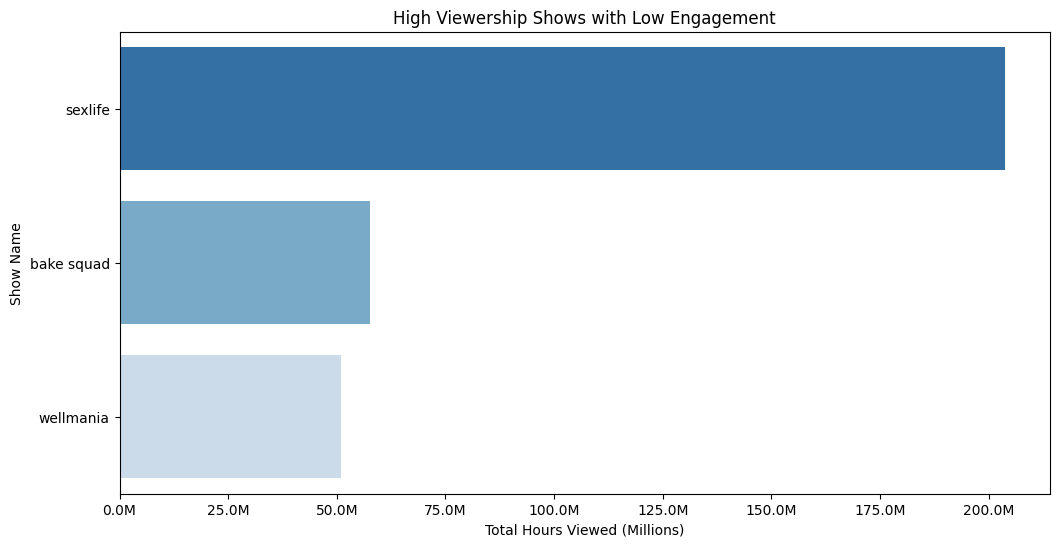

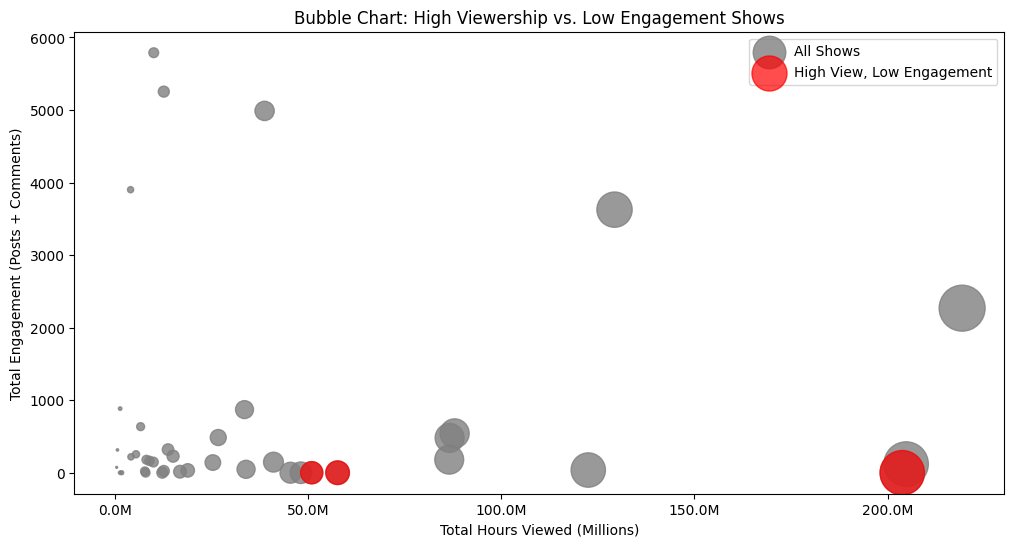

In [10]:
# (Low Engagement = Posts + Comments < Threshold) 
# Actually became more of a measure of the success of the API calls
engage_thresh = 10
high_viewership_thresh = aggregated_df["Total Hours Viewed in 2023"].quantile(0.75)  # Top 25% views
aggregated_df["Total Engagement"] = aggregated_df["Total Posts (2023)"] + aggregated_df["Total Comments (2023)"]
high_view_low_engagement = aggregated_df[(aggregated_df["Total Hours Viewed in 2023"] >= high_viewership_thresh) & (aggregated_df["Total Engagement"] < engage_thresh)].sort_values(by="Total Hours Viewed in 2023", ascending=False)

# Visualization 1: Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(
    data = high_view_low_engagement,
    x = "Total Hours Viewed in 2023",
    y = "Normalized_Show_Name",
    palette = "Blues_r"
)
plt.xlabel("Total Hours Viewed (Millions)")
plt.ylabel("Show Name")
plt.title("High Viewership Shows with Low Engagement")
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()


# Visualization 2: Bubble Chart
plt.figure(figsize = (12, 6))
plt.scatter(
    aggregated_df["Total Hours Viewed in 2023"],
    aggregated_df["Total Engagement"],
    s = aggregated_df["Total Hours Viewed in 2023"] / 2e5, 
    alpha = 0.8,
    label = "All Shows",
    color = "gray"
)
plt.scatter(
    high_view_low_engagement["Total Hours Viewed in 2023"],
    high_view_low_engagement["Total Engagement"],
    s=high_view_low_engagement["Total Hours Viewed in 2023"] / 2e5,
    alpha = 0.7,
    label = "High View, Low Engagement",
    color = "red"
)
plt.xlabel("Total Hours Viewed (Millions)")
plt.ylabel("Total Engagement (Posts + Comments)")
plt.title("Bubble Chart: High Viewership vs. Low Engagement Shows")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()


### Step 2.4: Total Hours Viewed and Total Number of Comments

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\841892626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


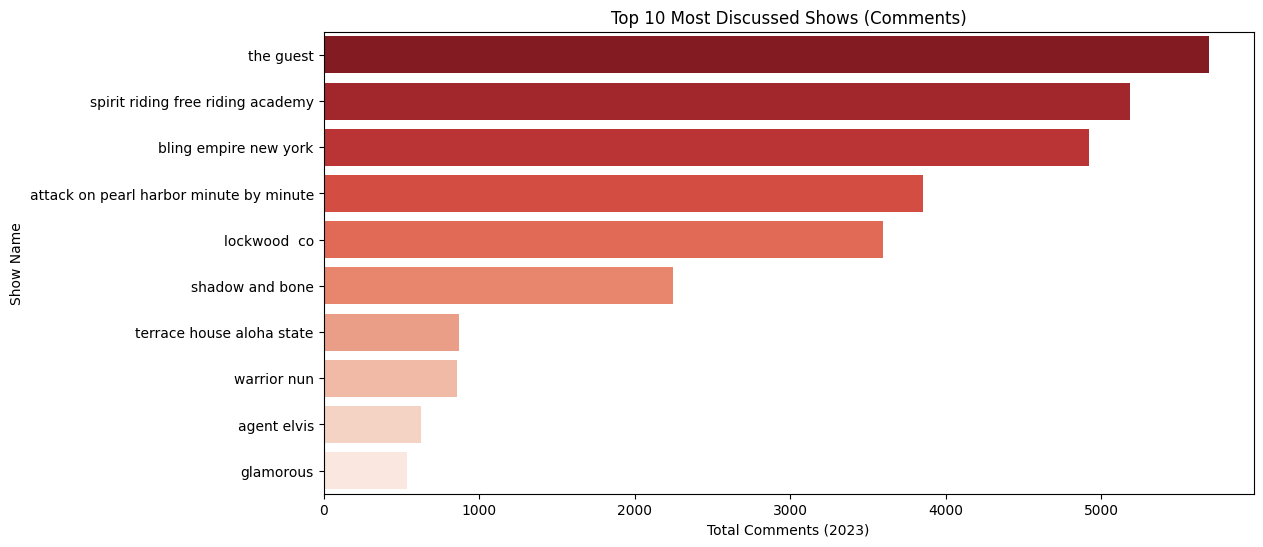

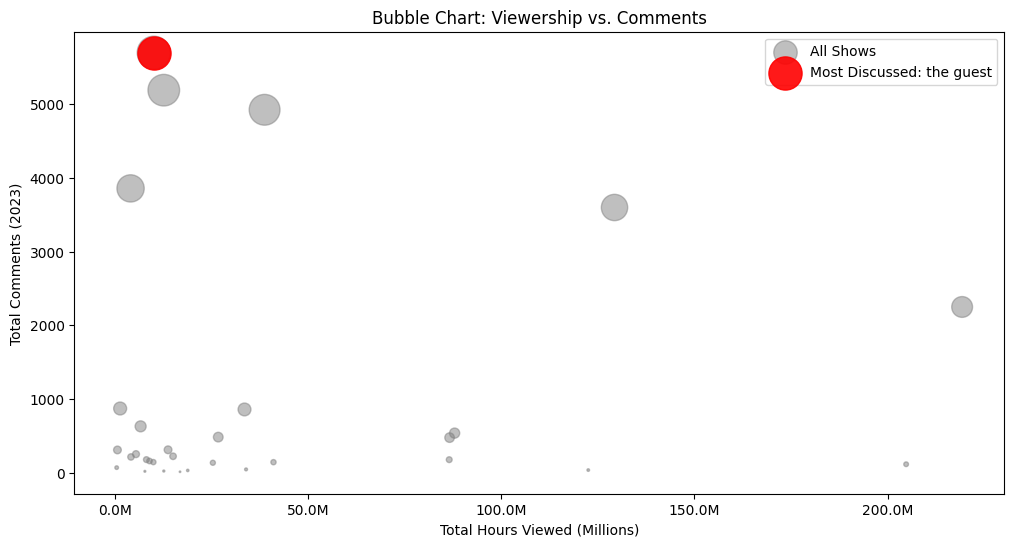

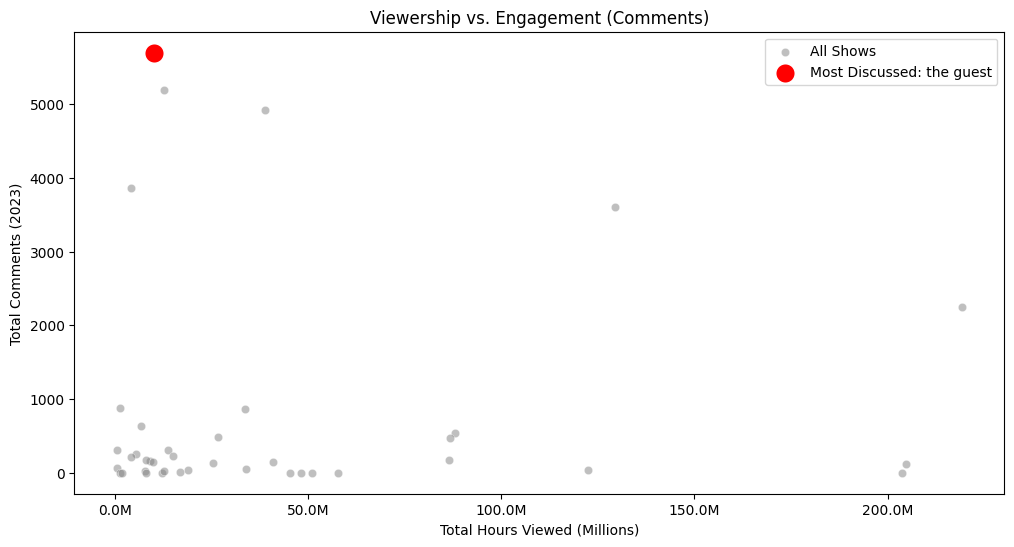

In [11]:
# Visualization 1: Bar Chart (Top Shows by Comments)
plt.figure(figsize = (12, 6))
sns.barplot(
    data = top_commented_shows,
    x = "Total Comments (2023)",
    y = "Normalized_Show_Name",
    palette = "Reds_r"
)
plt.xlabel("Total Comments (2023)")
plt.ylabel("Show Name")
plt.title("Top 10 Most Discussed Shows (Comments)")
plt.show()

# Visualization 2: Bubble Chart (Viewership vs. Comments)
plt.figure(figsize=(12, 6))
plt.scatter(
    aggregated_df["Total Hours Viewed in 2023"],
    aggregated_df["Total Comments (2023)"],
    s = aggregated_df["Total Comments (2023)"] / 10, 
    alpha = 0.5,
    label = "All Shows",
    color = "gray"
)
plt.scatter(
    most_discussed_show["Total Hours Viewed in 2023"],
    most_discussed_show["Total Comments (2023)"],
    s = most_discussed_show["Total Comments (2023)"] / 10,
    alpha = 0.9,
    label = f"Most Discussed: {most_discussed_show['Normalized_Show_Name']}",
    color = "red"
)
plt.xlabel("Total Hours Viewed (Millions)")
plt.ylabel("Total Comments (2023)")
plt.title("Bubble Chart: Viewership vs. Comments")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter)) 
plt.show()

# Visualization 3: Scatter Plot (Viewership vs. Comments)
plt.figure(figsize = (12, 6))
sns.scatterplot(
    data = aggregated_df,
    x = "Total Hours Viewed in 2023",
    y = "Total Comments (2023)",
    color = "gray",
    alpha = 0.5,
    label = "All Shows"
)
sns.scatterplot(
    x = [most_discussed_show["Total Hours Viewed in 2023"]],
    y = [most_discussed_show["Total Comments (2023)"]],
    color = "red",
    s = 200,
    label = f"Most Discussed: {most_discussed_show['Normalized_Show_Name']}"
)
plt.xlabel("Total Hours Viewed (Millions)")
plt.ylabel("Total Comments (2023)")
plt.title("Viewership vs. Engagement (Comments)")
plt.legend()
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.show()


### Step 2.5: Differences in Mean Viewership Between Cancelled and Non-Cancelled Shows

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\231102772.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


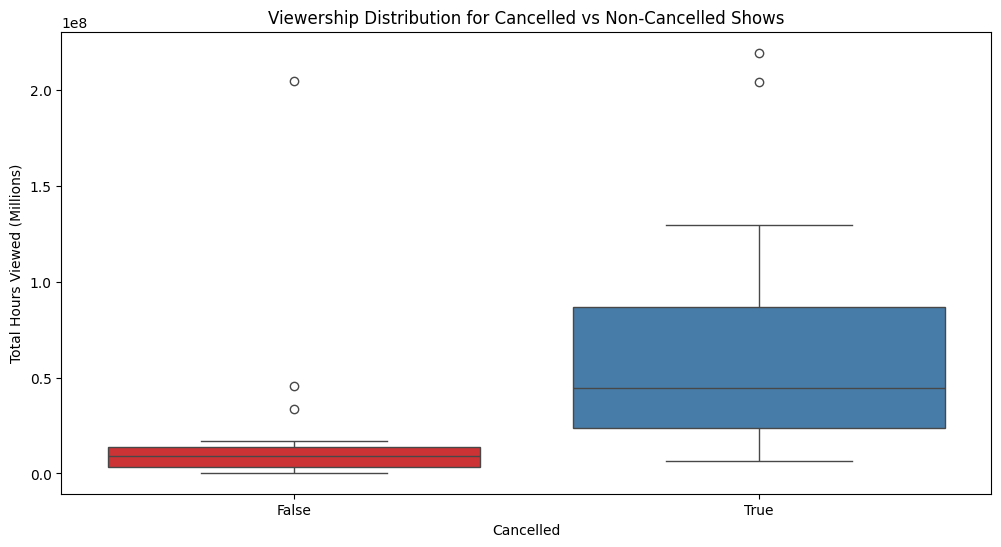

In [12]:
# Visualization 1: Box Plot (Viewership Distribution)
plt.figure(figsize = (12, 6))
sns.boxplot(
    x = "Cancelled", 
    y = "Total Hours Viewed in 2023", 
    data = aggregated_df, 
    palette = "Set1"
)
plt.ylabel("Total Hours Viewed (Millions)")
plt.title("Viewership Distribution for Cancelled vs Non-Cancelled Shows")
plt.show()

In [13]:
# Determine the T-statistic and its corresponding P-value
t_stat, p_value = stats.ttest_ind(
    cancelled_shows["Total Hours Viewed in 2023"], 
    non_cancelled_shows["Total Hours Viewed in 2023"]
)

# Print the T-statistic and P-value
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Print the conclusion to the statistical test results
if p_value < 0.05: 
    print("There is a statistically significant difference in the average viewership between cancelled and non-cancelled shows.")
else: 
    print("There is no statistically significant difference in the average viewership between cancelled and non-cancelled shows.")

T-statistic: 2.646
P-value: 0.012
There is a statistically significant difference in the average viewership between cancelled and non-cancelled shows.


#TODO: observe that viewership is higher for cancelled shows

### Step 2.6: Differences in the mean number of posts between cancelled and non-cancelled shows

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\2016602740.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


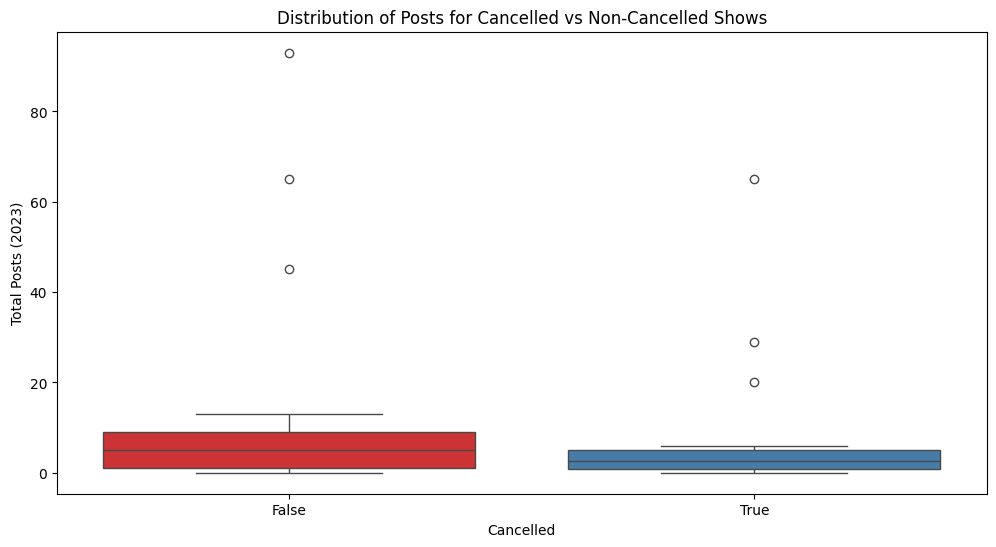

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\2016602740.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


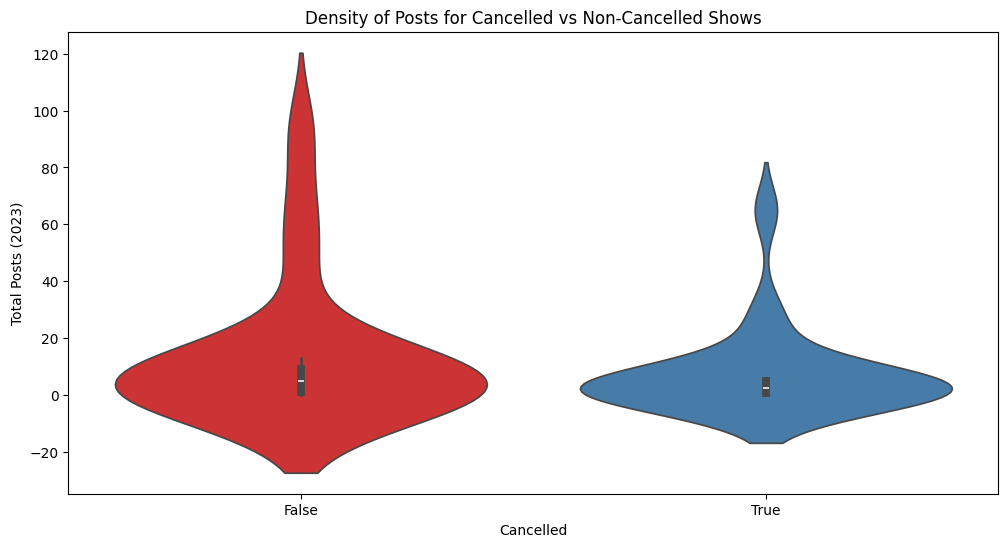

In [14]:
# Visualization 1: Box Plot (Distribution of Posts for Cancelled vs Non-Cancelled Shows)
plt.figure(figsize=(12, 6))
sns.boxplot(
    x = "Cancelled", 
    y = "Total Posts (2023)", 
    data = aggregated_df, 
    palette = "Set1"
)
plt.ylabel("Total Posts (2023)")
plt.title("Distribution of Posts for Cancelled vs Non-Cancelled Shows")
plt.show()

# Visualization 2: Violin Plot (Post Distribution Density for Cancelled vs Non-Cancelled Shows)
plt.figure(figsize=(12, 6))
sns.violinplot(
    x = "Cancelled", 
    y = "Total Posts (2023)", 
    data = aggregated_df, 
    palette = "Set1"
)
plt.ylabel("Total Posts (2023)")
plt.title("Density of Posts for Cancelled vs Non-Cancelled Shows")
plt.show()

In [15]:
# Calculate the T-statistic and its corresponding P-value
t_stat_posts, p_value_posts = stats.ttest_ind(
    cancelled_shows["Total Posts (2023)"], 
    non_cancelled_shows["Total Posts (2023)"]
)

# Print the T-statistic and P-value
print(f"T-statistic for Posts: {t_stat_posts:.3f}")
print(f"P-value for Posts: {p_value_posts:.3f}")

# Print the conclusion to the statistical test results
if p_value_posts < 0.05: 
    print("There is a statistically significant difference in the number of posts between cancelled and non-cancelled shows.")
else: 
    print("There is no statistically significant difference in the number of posts between cancelled and non-cancelled shows.")

T-statistic for Posts: -0.902
P-value for Posts: 0.373
There is no statistically significant difference in the number of posts between cancelled and non-cancelled shows.


#TODO: write conclusion to above statistical test results

### Step 2.7: Differences in the mean number of comments between cancelled and non-cancelled shows.

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\2259093347.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


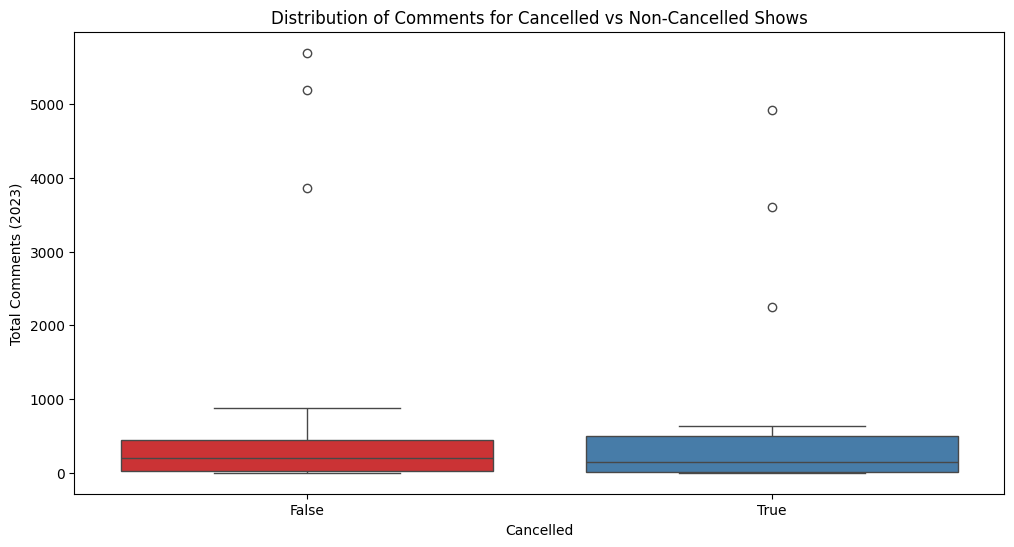

C:\Users\kevyn\AppData\Local\Temp\ipykernel_16512\2259093347.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


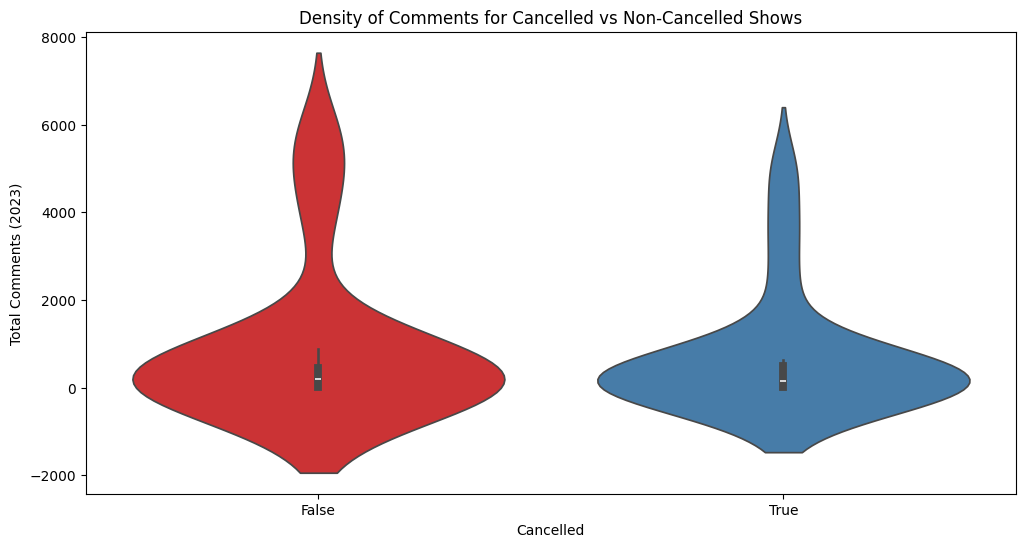

In [16]:
# Visualization 1: Box Plot (Distribution of Comments for Cancelled vs Non-Cancelled Shows)
plt.figure(figsize = (12, 6))
sns.boxplot(
    x = "Cancelled", 
    y = "Total Comments (2023)", 
    data = aggregated_df, 
    palette = "Set1"
)
plt.ylabel("Total Comments (2023)")
plt.title("Distribution of Comments for Cancelled vs Non-Cancelled Shows")
plt.show()

# Visualization 2: Violin Plot (Comment Distribution Density for Cancelled vs Non-Cancelled Shows)
plt.figure(figsize = (12, 6))
sns.violinplot(
    x = "Cancelled", 
    y = "Total Comments (2023)", 
    data = aggregated_df, 
    palette = "Set1"
)
plt.ylabel("Total Comments (2023)")
plt.title("Density of Comments for Cancelled vs Non-Cancelled Shows")
plt.show()

In [17]:

# Calculate the T-statistic and its corresponding P-value
t_stat_comments, p_value_comments = stats.ttest_ind(
    cancelled_shows["Total Comments (2023)"], 
    non_cancelled_shows["Total Comments (2023)"]
)

# Print the T-statistic and P-value
print(f"T-statistic for Comments: {t_stat_comments:.3f}")
print(f"P-value for Comments: {p_value_comments:.3f}")

# Print the conclusion to the statistical test results
if p_value_comments < 0.05: 
    print("There is a statistically significant difference in the number of comments between cancelled and non-cancelled shows.")
else: 
    print("There is no statistically significant difference in the number of comments between cancelled and non-cancelled shows.")

T-statistic for Comments: -0.472
P-value for Comments: 0.640
There is no statistically significant difference in the number of comments between cancelled and non-cancelled shows.


#TODO: Write conclusion to above statistical test results.

### Step 2.8: Correlation between the number of posts and total hours viewed

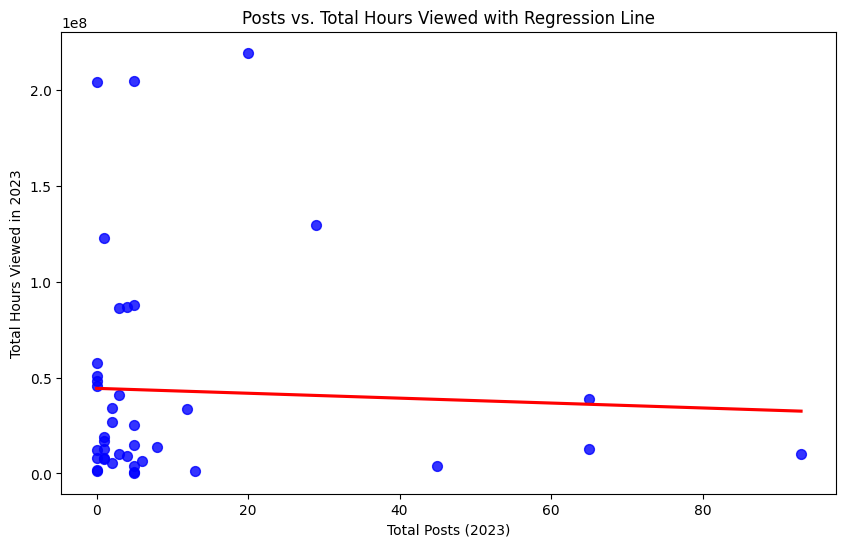

In [18]:
# Visualization: Scatter Plot with Regression Line (Posts vs. Total Hours Viewed)
plt.figure(figsize = (10, 6))
sns.regplot(
    x = "Total Posts (2023)", 
    y = "Total Hours Viewed in 2023", 
    data = aggregated_df, 
    scatter_kws = {'s': 50, 'color': 'blue'},
    line_kws = {'color': 'red'}, 
    ci = None 
)
plt.xlabel("Total Posts (2023)")
plt.ylabel("Total Hours Viewed in 2023")
plt.title("Posts vs. Total Hours Viewed with Regression Line")
plt.show()


In [19]:
# Calculate the Pearson Correlation Coefficient and its corresponding P-value
corr, p_value = stats.pearsonr(
    aggregated_df["Total Posts (2023)"], 
    aggregated_df["Total Hours Viewed in 2023"]
)

# Print the Pearson Correlation Coefficient and P-value
print(f"Pearson Correlation Coefficient: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

# Print the conclusion to the statistical test results
if p_value < 0.05: 
    print("There is a statistically significant positive correlation between the number of posts and total hours viewed.")
else: 
    print("There is no statistically significant correlation between the number of posts and total hours viewed.")


Pearson Correlation Coefficient: -0.045
P-value: 0.780
There is no statistically significant correlation between the number of posts and total hours viewed.


#TODO: write conclusion to above statistical test results

### Step 2.9: Correlation between the number of posts and the number of comments

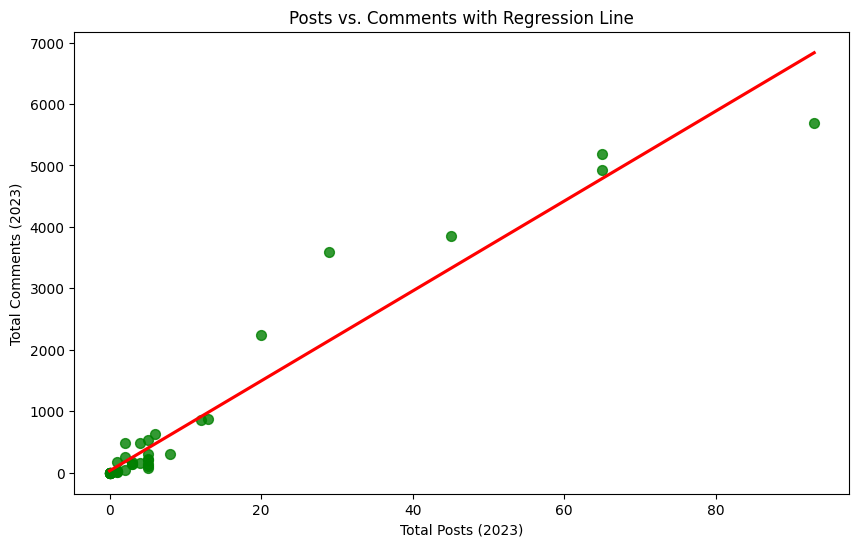

In [20]:
# Visualization: Scatter Plot with Regression Line (Posts vs. Comments), aggregate dataset
plt.figure(figsize = (10, 6))
sns.regplot(
    x = "Total Posts (2023)", 
    y = "Total Comments (2023)", 
    data = aggregated_df, 
    scatter_kws = {'s': 50, 'color': 'green'}, 
    line_kws = {'color': 'red'}, 
    ci = None
)
plt.xlabel("Total Posts (2023)")
plt.ylabel("Total Comments (2023)")
plt.title("Posts vs. Comments with Regression Line")
plt.show()


In [21]:
# Calculate the Pearson Correlation Coefficient and its corresponding P-value
corr_posts_comments_aggregate_df, p_value_posts_comments_aggregate_df = stats.pearsonr(
    aggregated_df["Total Posts (2023)"], 
    aggregated_df["Total Comments (2023)"]
)

# Print the Pearson Correlation Coefficient and P-value
print(f"Pearson Correlation Coefficient (Posts vs Comments): {corr_posts_comments_aggregate_df:.3f}")
print(f"P-value: {p_value_posts_comments_aggregate_df:.3f}")

# Print the conclusion to the statistical test results
if p_value_posts_comments_aggregate_df < 0.05: 
    print("There is a statistically significant positive correlation between the number of posts and the number of comments.")
else: 
    print("There is no statistically significant correlation between the number of posts and the number of comments.")


Pearson Correlation Coefficient (Posts vs Comments): 0.972
P-value: 0.000
There is a statistically significant positive correlation between the number of posts and the number of comments.


#TODO: write conclusion to above statistical test results

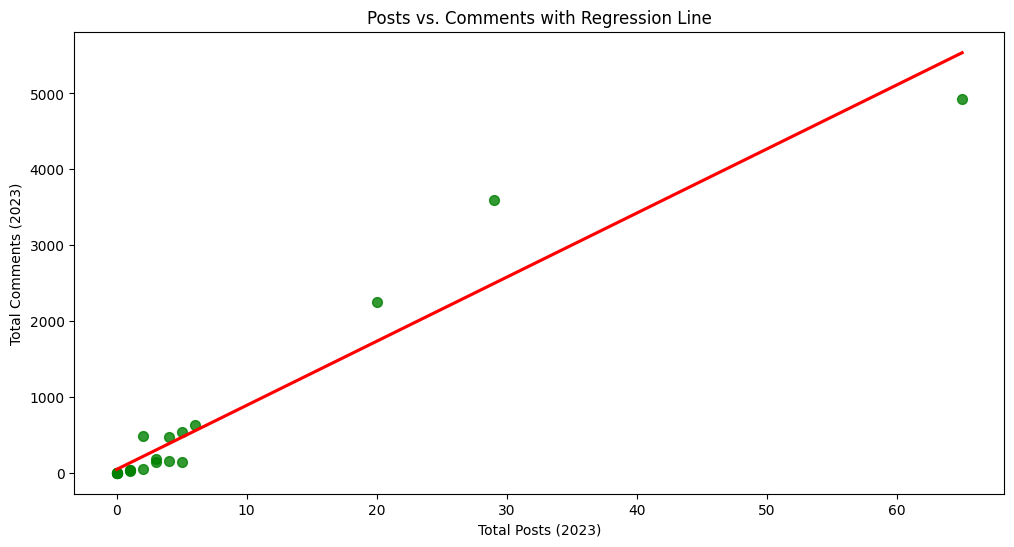

In [22]:
# Visualization: Scatter Plot with Regression Line (Posts vs. Comments), cancelled shows
plt.figure(figsize = (12, 6))
sns.regplot(
    x = "Total Posts (2023)", 
    y = "Total Comments (2023)", 
    data = cancelled_shows, 
    scatter_kws = {'s': 50, 'color': 'green'}, 
    line_kws = {'color': 'red'}, 
    ci = None
)
plt.xlabel("Total Posts (2023)")
plt.ylabel("Total Comments (2023)")
plt.title("Posts vs. Comments with Regression Line")
plt.show()


In [23]:
# Calculate the Pearson Correlation Coefficient and its corresponding P-value
corr_posts_comments_cancelled, p_value_posts_comments_cancelled = stats.pearsonr(
    cancelled_shows["Total Posts (2023)"],
    cancelled_shows["Total Comments (2023)"]
)

# Print the Pearson Correlation Coefficient and P-value
print(f"Pearson Correlation Coefficient (Posts vs Comments): {corr_posts_comments_cancelled:.3f}")
print(f"P-value: {p_value_posts_comments_cancelled:.3f}")

# Print the conclusion to the statistical test results
if p_value_posts_comments_cancelled < 0.05: 
    print("There is a statistically significant positive correlation between the number of posts and the number of comments.")
else: 
    print("There is no statistically significant correlation between the number of posts and the number of comments.")


Pearson Correlation Coefficient (Posts vs Comments): 0.967
P-value: 0.000
There is a statistically significant positive correlation between the number of posts and the number of comments.


#TODO: write conclusion to above statistical test results

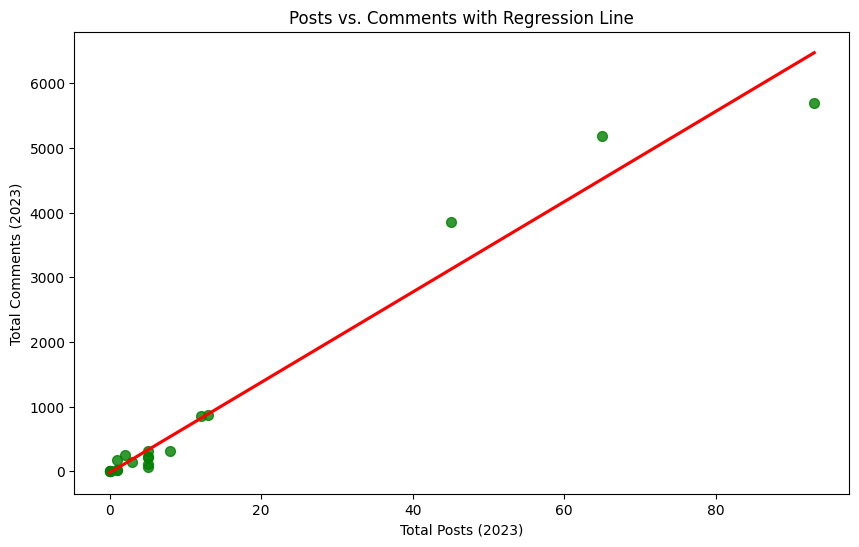

In [24]:
# Visualization: Scatter Plot with Regression Line (Posts vs. Comments), non-cancelled shows
plt.figure(figsize = (10, 6))
sns.regplot(
    x = "Total Posts (2023)", 
    y = "Total Comments (2023)", 
    data = non_cancelled_shows, 
    scatter_kws = {'s': 50, 'color': 'green'}, 
    line_kws = {'color': 'red'}, 
    ci = None
)
plt.xlabel("Total Posts (2023)")
plt.ylabel("Total Comments (2023)")
plt.title("Posts vs. Comments with Regression Line")
plt.show()


In [25]:
# Calculate the Pearson correlation coefficient and its corresponding p-value
corr_posts_comments_non_cancelled, p_value_posts_comments_non_cancelled = stats.pearsonr(
    non_cancelled_shows["Total Posts (2023)"], 
    non_cancelled_shows["Total Comments (2023)"]
)

# Print the results of the statistical test
print(f"Pearson Correlation Coefficient (Posts vs Comments): {corr_posts_comments_non_cancelled:.3f}")
print(f"P-value: {p_value_posts_comments_non_cancelled:.3f}")

# Print the conclusion to the statistical test results
if p_value_posts_comments_non_cancelled < 0.05: 
    print("There is a statistically significant positive correlation between number of posts and the number of comments.")
else: 
    print("There is no statistically significant correlation between the number of posts and the number of comments.")

Pearson Correlation Coefficient (Posts vs Comments): 0.985
P-value: 0.000
There is a statistically significant positive correlation between number of posts and the number of comments.


#TODO: write conclusion to above statistical test results

## Step 3: Answering Research Questions
Here, we answer the main research question: <br>

#### Does audience engagement, measured as the number of hours viewed and the volume of discussions on Reddit in 2023, influence the cancellation of Netflix TV shows?

---

### Step 3.1: Sub-Questions

#### Is the total number of hours that the final season of Netflix TV shows are viewed in 2023 correlated with them having been cancelled?

$H_0$: There is no correlation between the total viewership hours and cancellation. <br>
$H_1$: There is a significant positive correlation between viewership hours and cancellation. <br>
$H_2$: There is a significant negative correlation between viewership hours and cancellation. <br>

In [26]:
# Calculate the point biserial correlation coefficient and its corresponding p-value
corr, p_value_corr = stats.pointbiserialr(
    aggregated_df["Cancelled"].astype(int), 
    aggregated_df["Total Hours Viewed in 2023"]
)

# Print the correlation coefficient r and p-value
print(f"Correlation: r = {corr:.4f}, p-value = {p_value_corr:.4f}")

# Print the conclusion to the statistical test results
if p_value_corr < 0.05:
    if corr > 0:
        print("Significant positive correlation: Higher viewership is correlated to more cancellations.")
    else: 
        print("Significant negative correlation: Higher viewership is correlated to fewer cancellations.")
else: 
    print("No significant correlation between viewership and cancellation.")

Correlation: r = 0.3944, p-value = 0.0118
Significant positive correlation: Higher viewership is correlated to more cancellations.


#TODO: Write conclusion to above statistical test results.

---

#### Is the volume of discussion on Reddit subreddits r/television (17 million members) and r/NetflixBestOf (11 million members) during the year of a Netflix TV show’s final season (2023) associated with it having been cancelled?

$H_0$: There is no correlation between the total discussion and cancellation. <br>
$H_1$: There is significant positive correlation between total discussion and cancellation <br>
$H_2$: There is significant negative correlation between total discussion and cancellation. <br>



In [27]:
# Create a Total Discussion value for each TV show by summing their number of posts and comments
aggregated_df["Total Discussion"] = aggregated_df["Total Posts (2023)"] + aggregated_df["Total Comments (2023)"]

# Calculate the point biserial correlation coefficient and its corresponding p-value
corr, p_value_corr = stats.pointbiserialr(
    aggregated_df["Cancelled"].astype(int), 
    aggregated_df["Total Discussion"]
)

# Print the correlation coefficient r and p-value
print(f"Correlation: r = {corr:.4f}, p-value = {p_value_corr:.4f}")

# Print the conclusion of the statistical test
if p_value_corr < 0.05:
    if corr > 0: 
        print("Significant positive correlation: increased discussion is correlated to more cancellations.")
    else: 
        print("Significant negative correlation: increased discussion is correllated to fewer cancellations.")
else: 
    print("No significant correlation between discussion volume and cancellation.")

Correlation: r = -0.0773, p-value = 0.6356
No significant correlation between discussion volume and cancellation.


#TODO: Write conclusion to above statistical test results.

---

### Step 3.2: Predicting Cancellations with Audience Engagement Using Logistic Regression

Testing whether independent variables $x_1$, $x_2$ and $x_3$ can be used to predict whether a TV show will be cancelled. Using the Wald-test to test model significance and evaluating pseudo-$R^2$ to see whether the model explains the variance in the dataset.

$x_1$: "total posts on reddit in 2023" <br>
$x_2$: "total comments on reddit in 2023" <br>
$x_3$: "total Netflix viewership in hours in 2023" <br>


$H_0$: Independent variables $x_1$, $x_2$, and $x_3$ are not sufficient to create a statistically significant ($p$ < 0.05) logistic regression model that predicts Netflix TV-Show cancellations and the model's pseudo-$R^2$ suggests weak explanatory power (pseudo-$R^2$ < 0.02). <br>

$H_1$: Independent variables $x_1$, $x_2$, and $x_3$ are sufficient to create a statistically significant ($p$ <0.05) logistic regression model that predicts Netflix TV-Show cancellations and the model's pseudo-$R^2$ suggests meaningful explanatory power (pseudo-$R^2$ > 0.02).

In [28]:
# Encode the target variable 'Cancelled' (True/False to 1/0)
aggregated_df['Cancelled'] = aggregated_df['Cancelled'].astype(int)

# Define independent variables (X) and the dependent variable (y)
X = aggregated_df[["Total Posts (2023)", "Total Comments (2023)", "Total Hours Viewed in 2023"]]
y = aggregated_df["Cancelled"]

# Split the data into training and test sets (80% raining, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Fit the Logistic Regression model
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
X_train_with_intercept = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_with_intercept)
result = logit_model.fit()

# Print the Logistic Regression Results
print(result.summary(), "\n")

# Use the trained model to make predictions on the test 
# data (X_test) and store the predicted values in y_pred
y_pred = model.predict(X_test)

# Print the confusion matrix and the classification report
print("Confusion Matrix:", confusion_matrix(y_test, y_pred), "\n")
print("\nClassification Report:", classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.516834
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Cancelled   No. Observations:                   32
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            3
Date:                Sun, 02 Feb 2025   Pseudo R-squ.:                  0.2458
Time:                        13:18:47   Log-Likelihood:                -16.539
converged:                       True   LL-Null:                       -21.930
Covariance Type:            nonrobust   LLR p-value:                   0.01296
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.4572      0.661      0.691      0.489      

In [29]:
# Print statistical significance of logistic regression model
if result.llr_pvalue < 0.05:
    print(f"The LLR p-value is {result.llr_pvalue:.4f}, which is less than 0.05. \nThe model as a whole is statistically significant.")
else:
    print(f"The LLR p-value is {result.llr_pvalue:.4f}, which is greater than 0.05. \nThe model as a whole is not statistically significant.")

# Print conclusion to the logistic regression results
print(f"\nThe Pseudo R-squared value is {result.prsquared:.4f}. This means that {result.prsquared * 100:.2f}% of the variance in the dependent variable (cancellation) is explained by the model.")

The LLR p-value is 0.0130, which is less than 0.05. 
The model as a whole is statistically significant.

The Pseudo R-squared value is 0.2458. This means that 24.58% of the variance in the dependent variable (cancellation) is explained by the model.


#TODO: Write conclusion to above statistical test